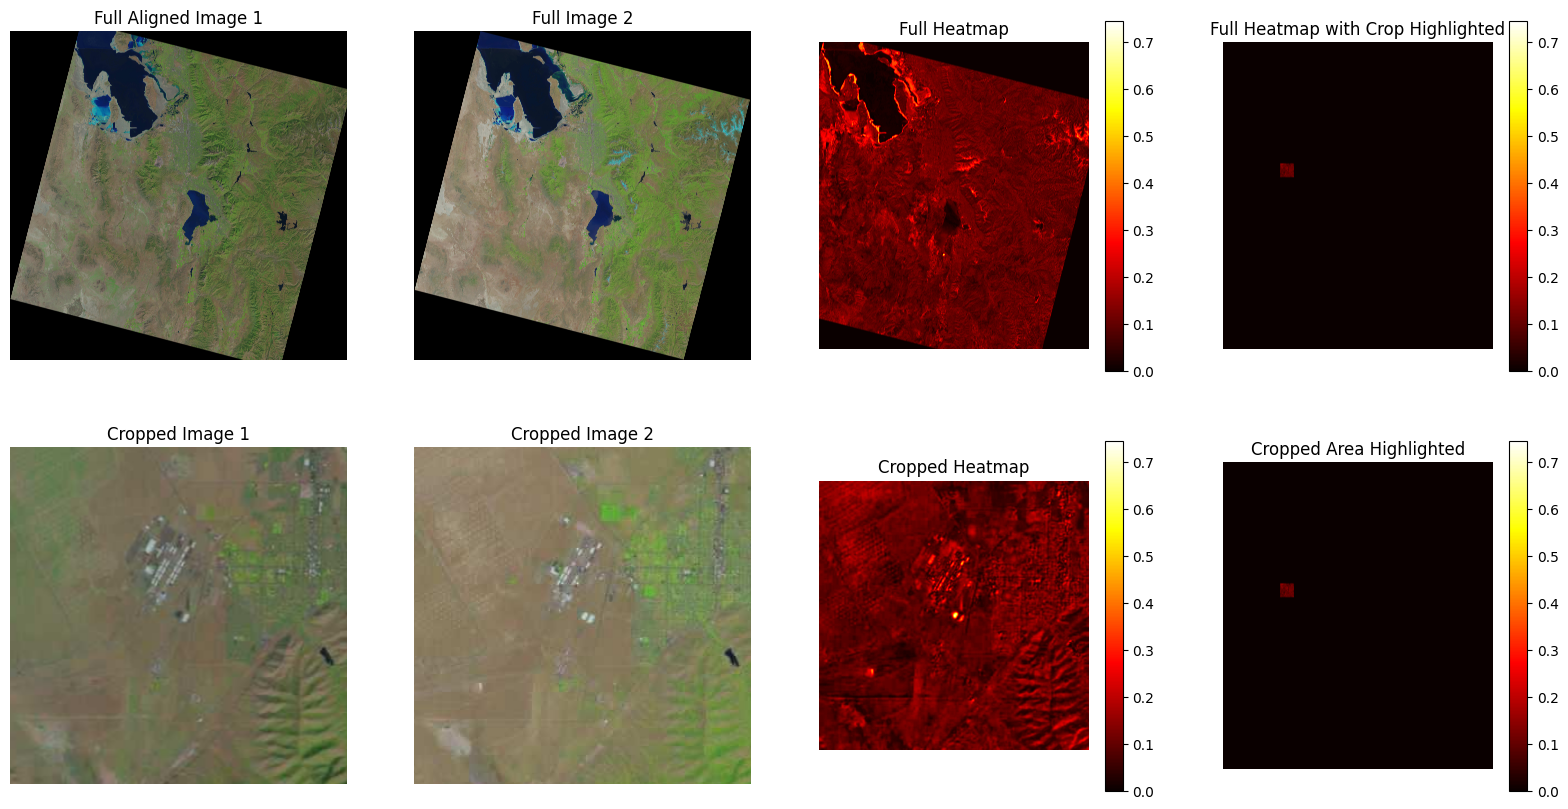

Przyrost pikseli kolorów między obrazami:
blue: 348504 pikseli (0.88%)
green: 19925 pikseli (0.05%)
brown: 131 pikseli (0.00%)
other: 0 pikseli (0.00%)


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Load images
nazwa2 = "LC08_L1TP_038032_20130609_20200913_02_T1.jpg"
nazwa1 = "LC08_L1TP_038032_20230925_20231002_02_T1.jpg"
img1 = cv2.imread('data/' + nazwa1)
img2 = cv2.imread('data/' + nazwa2)

# Convert to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Feature detection using ORB
orb = cv2.ORB_create()
keypoints1, descriptors1 = orb.detectAndCompute(gray1, None)
keypoints2, descriptors2 = orb.detectAndCompute(gray2, None)

# Feature matching using BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Extract keypoints from matches
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 2)
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 2)

# Compute homography matrix
H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

# Warp perspective
height, width, channels = img2.shape
aligned_img1 = cv2.warpPerspective(img1, H, (width, height))

# Find common cropping area
x_min = int(max(pts2[:, 0].min(), 0))
x_max = int(min(pts2[:, 0].max(), width))
y_min = int(max(pts2[:, 1].min(), 0))
y_max = int(min(pts2[:, 1].max(), height))

# Crop images to common area
cropped_img1 = aligned_img1[y_min:y_max, x_min:x_max]
cropped_img2 = img2[y_min:y_max, x_min:x_max]

# Convert cropped images to NumPy arrays
image1_np = np.array(cropped_img1)
image2_np = np.array(cropped_img2)

# Compute difference
difference = np.abs(image1_np.astype(int) - image2_np.astype(int))

# Normalize difference for display
difference_normalized = (difference - difference.min()) / (difference.max() - difference.min())

# Reduce to one channel
if difference_normalized.ndim == 3:
    difference_normalized = np.mean(difference_normalized, axis=2)

# Detect non-black pixels in images
threshold = 30
non_black_mask = (cropped_img1 > threshold).any(axis=2) & (cropped_img2 > threshold).any(axis=2)

# Apply mask to difference map
difference_normalized[~non_black_mask] = 0

# Find area with the most significant difference
(y, x) = np.unravel_index(np.argmax(difference_normalized), difference_normalized.shape)

# Determine coordinates for cropping
half_size = 150  # half of 300
start_x = max(x - half_size, 0)
start_y = max(y - half_size, 0)
end_x = min(start_x + 300, width)
end_y = min(start_y + 300, height)

# Crop the area with the most significant changes
crop_diff = difference_normalized[start_y:end_y, start_x:end_x]
crop_img1 = cropped_img1[start_y:end_y, start_x:end_x]
crop_img2 = cropped_img2[start_y:end_y, start_x:end_x]

# Klasyfikacja kolorów
def classify_color(pixel):
    b, g, r = pixel
    if b > 1.5 * g and b > 1.5 * r:
        return 'blue'
    elif g > 1.5 * b and g > 1.5 * r:
        return 'green'
    elif r > 1.5 * b and r > 1.5 * g:
        return 'brown'
    else:
        return 'other'

# Analiza przyrostu pikseli kolorów
color_gains = {
    'blue': 0,
    'green': 0,
    'brown': 0,
    'other': 0
}

for i in range(image1_np.shape[0]):
    for j in range(image1_np.shape[1]):
        if difference_normalized[i, j] >= 0.2:  # Bierzemy pod uwagę tylko piksele, które zmieniają się o >= 0.2
            color1 = classify_color(image1_np[i, j])
            color2 = classify_color(image2_np[i, j])
            if color2 != 'other' and color1 != color2:
                color_gains[color2] += 1

# Compute total number of pixels
total_pixels = image1_np.shape[0] * image1_np.shape[1]

# Compute percentage of pixel gains
color_gains_percentage = {color: (count / total_pixels) * 100 for color, count in color_gains.items()}

# Display images side by side
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# Display the full aligned image 1
axs[0, 0].imshow(cv2.cvtColor(aligned_img1, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Full Aligned Image 1')
axs[0, 0].axis('off')

# Display the full image 2
axs[0, 1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title('Full Image 2')
axs[0, 1].axis('off')

# Display the full heatmap
cax_full = axs[0, 2].imshow(difference_normalized, cmap='hot', interpolation='bicubic')
axs[0, 2].set_title('Full Heatmap')
axs[0, 2].axis('off')

# Add colorbar to the full heatmap
fig.colorbar(cax_full, ax=axs[0, 2], orientation='vertical')

# Display the cropped area on the heatmap
full_diff = np.zeros_like(difference_normalized)
full_diff[start_y:end_y, start_x:end_x] = crop_diff
cax_highlight = axs[0, 3].imshow(full_diff, cmap='hot', interpolation='bicubic')
axs[0, 3].set_title('Full Heatmap with Crop Highlighted')
axs[0, 3].axis('off')

# Add colorbar to the highlighted heatmap
fig.colorbar(cax_highlight, ax=axs[0, 3], orientation='vertical')

# Display the cropped image 1
axs[1, 0].imshow(cv2.cvtColor(crop_img1, cv2.COLOR_BGR2RGB))
axs[1, 0].set_title('Cropped Image 1')
axs[1, 0].axis('off')

# Display the cropped image 2
axs[1, 1].imshow(cv2.cvtColor(crop_img2, cv2.COLOR_BGR2RGB))
axs[1, 1].set_title('Cropped Image 2')
axs[1, 1].axis('off')

# Display the cropped heatmap
cax_crop = axs[1, 2].imshow(crop_diff, cmap='hot', interpolation='bicubic')
axs[1, 2].set_title('Cropped Heatmap')
axs[1, 2].axis('off')

# Add colorbar to the cropped heatmap
fig.colorbar(cax_crop, ax=axs[1, 2], orientation='vertical')

# Display the combined heatmap with the crop highlighted
cax_combined = axs[1, 3].imshow(full_diff, cmap='hot', interpolation='bicubic')
axs[1, 3].set_title('Cropped Area Highlighted')
axs[1, 3].axis('off')

# Add colorbar to the combined heatmap
fig.colorbar(cax_combined, ax=axs[1, 3], orientation='vertical')

# Show images
plt.show()

# Wyświetlenie wyników analizy
print("Przyrost pikseli kolorów między obrazami:")
for color, count in color_gains.items():
    percentage = color_gains_percentage[color]
    print(f"{color}: {count} pikseli ({percentage:.2f}%)")